In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBClassifier
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import cross_val_score
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
train_basic_fuzzy = pd.read_csv('train_basic_fuzzy.csv', sep=',')

In [3]:
train_basic_fuzzy.drop(['question1_form','question2_form'], axis=1, inplace=True)

In [4]:
# Check the feature values for any kind of imputation
train_basic_fuzzy.count()

is_duplicate                404290
q1_form_len                 404290
q2_form_len                 404290
q1_length                   404290
q2_length                   404290
q1_unique                   404290
q2_unique                   404290
q1_form_uni                 404290
q2_form_uni                 404290
q1_form_char                404290
q2_form_char                404290
q1_q2_char_diff             404290
common_cnt                  404290
prcnt_common                404290
partial_ratio               404290
partial_token_set_ratio     404290
partial_token_sort_ratio    404290
q_ratio                     404290
token_set_ratio             404290
token_sort_ratio            404290
w_ratio                     404290
dtype: int64

In [5]:
val_dup = train_basic_fuzzy["is_duplicate"]
train_basic_fuzzy.drop(['is_duplicate'], axis=1, inplace=True)

In [6]:
val_dup = pd.DataFrame(pd.Series(val_dup))

In [7]:
# Separate into Train and Validation
import random
random.seed(45)
from sklearn.cross_validation import train_test_split
X_train, X_val, Y_train, Y_val = sklearn.cross_validation.train_test_split(train_basic_fuzzy, val_dup, 
                                                                           test_size = 0.2, random_state = 5)

In [46]:
# xgboost fn
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=Y_train[[0]].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=['logloss'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain[predictors], np.ravel(Y_train),eval_metric='logloss')     #Fit algorithm

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    print("AUC Score (Train): %f" % roc_auc_score(np.ravel(Y_train), dtrain_predprob))
    print("Log Loss (Train): %f " % log_loss(np.ravel(Y_train), dtrain_predprob))
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [16]:
# xgboost classifier : Using the best params from the Basic Features Model
xgb_log1 = XGBClassifier(max_depth= 6, min_child_weight= 2,gamma=0.3, colsample_bytree=0.9, subsample=0.7, reg_alpha = 1, 
                     reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 2, learning_rate = 0.05, n_estimators=700,
                     objective= 'binary:logistic', nthread=4, seed=45)

Will train until cv error hasn't decreased in 50 rounds.


AUC Score (Train): 0.836430


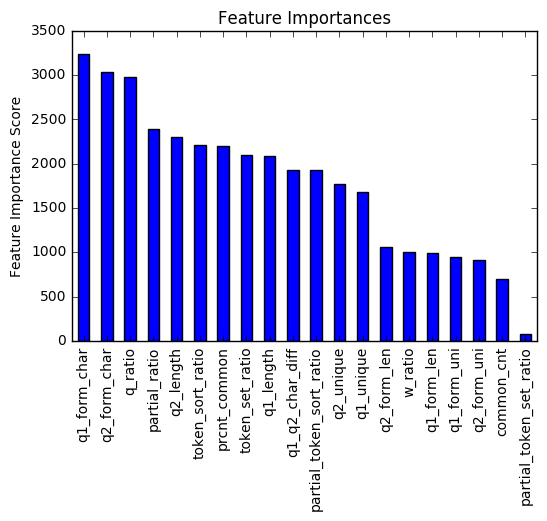

In [17]:
predictors  = list(X_train.columns)
modelfit(xgb_log1, X_train, predictors)

In [19]:
# Train log_loss
from sklearn.metrics import log_loss
y_predS = xgb_log1.predict_proba(X_train)
log_loss(Y_train, y_predS[:,1])

0.50362095607922541

In [20]:
# Cross validation AUC & log_loss
cv_score = cross_val_score(xgb_log1, X_train, np.ravel(Y_train), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score.mean()))
print('std auc: ' + str(cv_score.std()))
cv_score1 = cross_val_score(xgb_log1, X_train, np.ravel(Y_train), cv = 5, scoring ='log_loss')
print 'mean log_loss: ' + str(cv_score1.mean())
print 'std log_loss: ' + str(cv_score1.std())

mean auc: 0.817536902394
std auc: 0.00123840355591
mean log_loss: -0.523938361528
std log_loss: 0.00126849898863


In [21]:
# Save the model
from sklearn.externals import joblib
joblib.dump(xgb_log1, '/home/pgoyal/quora/model3/xgb_log1_dup_logloss.pkl')

['/home/pgoyal/quora/model3/xgb_log1_dup_logloss.pkl',
 '/home/pgoyal/quora/model3/xgb_log1_dup_logloss.pkl_01.npy']

In [22]:
# Validation AUC
val_pred = xgb_log1.predict_proba(X_val)
print('Validation AUC: ' + str(roc_auc_score(Y_val, val_pred[:,1])))
print 'Validation log_loss: ' + str(log_loss(Y_val, val_pred[:,1]))

Validation AUC: 0.816928566609
Validation log_loss: 0.524868539081


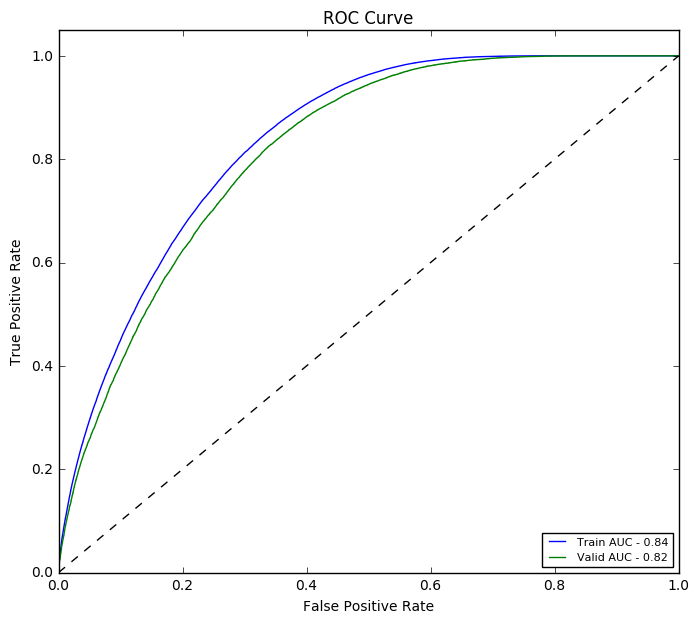

In [23]:
# Make ROC curve for train and validation
from sklearn.metrics import roc_curve, auc

fpr_trn, tpr_trn, _= roc_curve(Y_train, y_predS[:,1])
fpr_tst, tpr_tst, _= roc_curve(Y_val, val_pred[:, 1]) 

roc_auc_trn = auc(fpr_trn, tpr_trn)
roc_auc_tst = auc(fpr_tst, tpr_tst)

# Plot of a ROC curve
plt.figure(figsize=(8,7))
plt.plot(fpr_trn, tpr_trn, label='Train AUC - %0.2f' % roc_auc_trn)
plt.plot(fpr_tst, tpr_tst, label='Valid AUC - %0.2f' % roc_auc_tst)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={'size':8})
# plt.savefig('ROC_Curve.png')

In [24]:
from sklearn import cross_validation
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV

In [25]:
# Initial set of parameters are taken from the final set of params from the Grid Search on the XGB roc-auc
ini_max_depth = 5
ini_min_child_weight= 2
ini_gamma= 0
ini_colsample_bytree=0.8
ini_subsample= 0.8
ini_reg_alpha =1
ini_reg_lambda =0
ini_max_delta_step= 3
ini_scale_pos_weight=1
ini_learning_rate = 0.05
ini_n_estimators = 700

In [27]:
# Tune tree pruning parameters: max_depth and min_child_weight
param_test1 = {
   'max_depth':[ 3, 4, 5,6],
   'min_child_weight':[1, 2, 3, 5, 6]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/quora/model3/gs_files/gs_search1.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.50036, std: 0.00084, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.50042, std: 0.00081, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: -0.50042, std: 0.00090, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.50038, std: 0.00089, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: -0.50042, std: 0.00091, params: {'max_depth': 3, 'min_child_weight': 6},
  mean: -0.49466, std: 0.00101, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -0.49477, std: 0.00101, params: {'max_depth': 4, 'min_child_weight': 2},
  mean: -0.49469, std: 0.00098, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.49475, std: 0.00100, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.49477, std: 0.00103, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: -0.49004, std: 0.00105, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: -0.49008, std: 0.00103, params: {'max_depth': 5, 'min_child_weight': 2},
  mean: -0.49011, std: 0.001

In [28]:
# Best till here : Order is on the basis of the params given!
ini_max_depth = gsearch1.best_params_.values()[0]
ini_min_child_weight = gsearch1.best_params_.values()[1]

In [29]:
# Tune tree pruning parameters: gamma
param_test2 = {
   'gamma':[i/10.0 for i in range(0,3)]
}

gsearch2 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test2, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch2.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch2.grid_scores_).to_csv('/home/pgoyal/quora/model3/gs_files/gs_search2.csv')
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -0.48628, std: 0.00106, params: {'gamma': 0.0},
  mean: -0.48628, std: 0.00097, params: {'gamma': 0.1},
  mean: -0.48626, std: 0.00108, params: {'gamma': 0.2}],
 {'gamma': 0.2},
 -0.48625575975413743)

In [30]:
# Best till here :
ini_gamma = gsearch2.best_params_.values()[0]

In [31]:
# Tune tree pruning parameters: subsample, colsample_bytree
param_test3 = {
  'subsample':[i/10.0 for i in range(6,9)],
 'colsample_bytree':[i/10.0 for i in range(6,9)]
}

gsearch3 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test3, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch3.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch3.grid_scores_).to_csv('/home/pgoyal/quora/model3/gs_files/gs_search3.csv')
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.48729, std: 0.00115, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.48688, std: 0.00104, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.48659, std: 0.00107, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.48688, std: 0.00105, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: -0.48654, std: 0.00129, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: -0.48647, std: 0.00107, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: -0.48650, std: 0.00117, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: -0.48609, std: 0.00120, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: -0.48626, std: 0.00108, params: {'subsample': 0.8, 'colsample_bytree': 0.8}],
 {'colsample_bytree': 0.8, 'subsample': 0.7},
 -0.48609146674397846)

In [32]:
# Best till here :
ini_subsample = gsearch3.best_params_.values()[0]
ini_colsample_bytree = gsearch3.best_params_.values()[1]

In [33]:
# Tune tree pruning parameters: reg_alpha
param_test4 = {
    'reg_alpha':[ 1e-2, 0.1, 1]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test4, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch4.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch4.grid_scores_).to_csv('/home/pgoyal/quora/model3/gs_files/gs_search4.csv')
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: -0.48664, std: 0.00102, params: {'reg_alpha': 0.01},
  mean: -0.48660, std: 0.00112, params: {'reg_alpha': 0.1},
  mean: -0.48609, std: 0.00120, params: {'reg_alpha': 1}],
 {'reg_alpha': 1},
 -0.48609146674397846)

In [34]:
# Best till here :
ini_reg_alpha= gsearch4.best_params_.values()[0]

In [35]:
# Tune tree pruning parameters: reg_lambda
param_test5 = {
  'reg_lambda':[0, 1,2, 3]
}

gsearch5 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test5, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch5.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch5.grid_scores_).to_csv('/home/pgoyal/quora/model3/gs_files/gs_search5.csv')
gsearch5.grid_scores_, gsearch5.best_params_, gsearch5.best_score_

([mean: -0.48609, std: 0.00120, params: {'reg_lambda': 0},
  mean: -0.48644, std: 0.00116, params: {'reg_lambda': 1},
  mean: -0.48654, std: 0.00117, params: {'reg_lambda': 2},
  mean: -0.48667, std: 0.00117, params: {'reg_lambda': 3}],
 {'reg_lambda': 0},
 -0.48609146674397846)

In [36]:
# Best till here :
ini_reg_lambda= gsearch5.best_params_.values()[0]

In [37]:
# Tune tree pruning parameters: max_delta_step
param_test6 = {
  'max_delta_step':[1,2,3]
}

gsearch6 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test6, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch6.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch6.grid_scores_).to_csv('/home/pgoyal/quora/model3/gs_files/gs_search6.csv')
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -0.48654, std: 0.00110, params: {'max_delta_step': 1},
  mean: -0.48621, std: 0.00097, params: {'max_delta_step': 2},
  mean: -0.48609, std: 0.00120, params: {'max_delta_step': 3}],
 {'max_delta_step': 3},
 -0.48609146674397846)

In [38]:
# Best till here :
ini_max_delta_step= gsearch6.best_params_.values()[0]

In [39]:
# Tune tree pruning parameters: scale_pos_weight
param_test7 = {
  'scale_pos_weight':[1, 2, 5]
}

gsearch7 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test7, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch7.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch7.grid_scores_).to_csv('/home/pgoyal/quora/model3/gs_files/gs_search7.csv')
gsearch7.grid_scores_, gsearch7.best_params_, gsearch7.best_score_

([mean: -0.48609, std: 0.00120, params: {'scale_pos_weight': 1},
  mean: -0.52387, std: 0.00113, params: {'scale_pos_weight': 2},
  mean: -0.68170, std: 0.00180, params: {'scale_pos_weight': 5}],
 {'scale_pos_weight': 1},
 -0.48609146674397846)

In [40]:
# Best till here :
ini_scale_pos_weight= gsearch7.best_params_.values()[0]

In [41]:
param_test8 = {
    'learning_rate':[0.03, 0.05],
    'n_estimators':[250, 500, 700]
}

gsearch8 = GridSearchCV(estimator = XGBClassifier(max_depth= ini_max_depth, min_child_weight= ini_min_child_weight,
                    gamma=ini_gamma, colsample_bytree=ini_colsample_bytree, subsample=ini_subsample, 
                    reg_alpha = ini_reg_alpha, reg_lambda = ini_reg_lambda, max_delta_step = ini_max_delta_step, 
                    scale_pos_weight= ini_scale_pos_weight, learning_rate = ini_learning_rate, 
                    n_estimators=ini_n_estimators, objective= 'binary:logistic', nthread=4, seed=45), 
param_grid = param_test8, scoring='log_loss',n_jobs=4,iid=False, cv=5)

gsearch8.fit(X_train,np.ravel(Y_train))
pd.Series(gsearch8.grid_scores_).to_csv('/home/pgoyal/quora/model3/gs_files/gs_search8.csv')
gsearch8.grid_scores_, gsearch8.best_params_, gsearch8.best_score_

([mean: -0.49980, std: 0.00098, params: {'n_estimators': 250, 'learning_rate': 0.03},
  mean: -0.49255, std: 0.00107, params: {'n_estimators': 500, 'learning_rate': 0.03},
  mean: -0.48971, std: 0.00108, params: {'n_estimators': 700, 'learning_rate': 0.03},
  mean: -0.49449, std: 0.00093, params: {'n_estimators': 250, 'learning_rate': 0.05},
  mean: -0.48854, std: 0.00112, params: {'n_estimators': 500, 'learning_rate': 0.05},
  mean: -0.48609, std: 0.00120, params: {'n_estimators': 700, 'learning_rate': 0.05}],
 {'learning_rate': 0.05, 'n_estimators': 700},
 -0.48609146674397846)

In [53]:
# Best till here :
ini_n_estimators= gsearch8.best_params_.values()[0]
ini_learning_rate= gsearch8.best_params_.values()[1]

In [54]:
print "max_depth", ini_max_depth
print "min_child_weight", ini_min_child_weight
print "gamma", ini_gamma
print "colsample_bytree", ini_colsample_bytree
print "subsample", ini_subsample
print "reg_alpha", ini_reg_alpha
print "reg_lambda", ini_reg_lambda
print "max_delta_step", ini_max_delta_step
print "scale_pos_weight", ini_scale_pos_weight
print "learning_rate", ini_learning_rate
print "n_estimators", ini_n_estimators

max_depth 6
min_child_weight 1
gamma 0.2
colsample_bytree 0.8
subsample 0.7
reg_alpha 1
reg_lambda 0
max_delta_step 3
scale_pos_weight 1
learning_rate 0.05
n_estimators 700


Will train until cv error hasn't decreased in 50 rounds.


AUC Score (Train): 0.837837
Log Loss (Train): 0.465680 


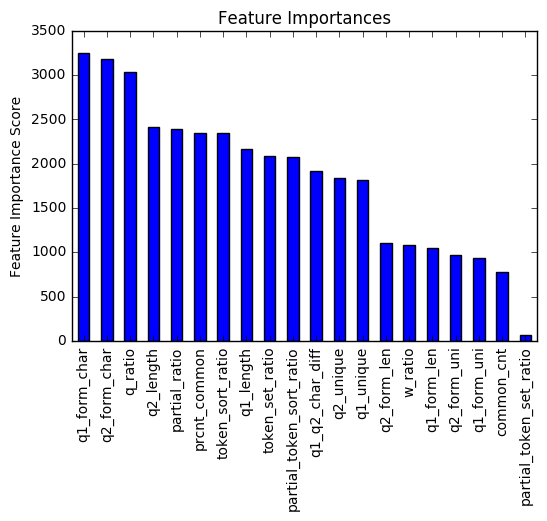

In [55]:
# Final xgboost classifier Using the final param values from the above GridSearch
xgb_log2 = XGBClassifier(max_depth= 6, min_child_weight= 1, gamma=0.2, colsample_bytree=0.8, subsample=0.7, 
                    reg_alpha = 1, reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 1, learning_rate = 0.05, 
                    n_estimators=700, objective= 'binary:logistic', nthread=4, seed=45)

#Choose the predictors for xgboost and fit the model
modelfit(xgb_log2, X_train, predictors)

In [56]:
# Train roc_auc & Log Loss
y_predS_xgb_log2 = xgb_log2.predict_proba(X_train)
print('Validation AUC: ' + str( roc_auc_score(Y_train, y_predS_xgb_log2[:,1]) ))
print('Validation LogLoss: ' + str( log_loss(Y_train, y_predS_xgb_log2[:,1]) ))

Validation AUC: 0.837837054551
Validation LogLoss: 0.4656798079


In [61]:
# Cross validation AUC 
cv_score_xgb_log2 = cross_val_score(xgb_log2, X_train, np.ravel(Y_train), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score_xgb_log2.mean()))
print('std auc: ' + str(cv_score_xgb_log2.std()))
cv_score1_xgb_log2 = cross_val_score(xgb_log2, X_train, np.ravel(Y_train), cv = 5, scoring ='log_loss')
print 'mean log_loss: ' + str(cv_score1_xgb_log2.mean())
print 'std log_loss: ' + str(cv_score1_xgb_log2.std())

mean auc: 0.818148170871
std auc: 0.00123205888108
mean log_loss: -0.486091466744
std log_loss: 0.00119910818177


In [57]:
# Save the model# Model with prcnt_common feature
from sklearn.externals import joblib
joblib.dump(xgb_log2, '/home/pgoyal/quora/model3/xgb_log2_dup_logloss.pkl')

['/home/pgoyal/quora/model3/xgb_log2_dup_logloss.pkl',
 '/home/pgoyal/quora/model3/xgb_log2_dup_logloss.pkl_01.npy']

## Decile Info - Train

In [58]:
# Decile related info

df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(y_predS_xgb_log2[:,1]) # y_predS is to be changed
prob.columns = ['Probability']
prob["Target"] = Y_train.values # y_train to be changed
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [59]:
# Decile info dataframe

df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

,# decile,# of goods,# of bads,1st decile capture_rate,1st decile response_rate,% of bads,% cum_goods,% cum_bads,KS,Lift
0,32343,26252.0,6091.0,0.219530,0.811675,0.029880,0.219530,0.029880,0.514382,2.195309
1,32343,22080.0,10263.0,0.184642,0.682682,0.050347,0.404171,0.080227,0.514382,2.020868
2,32343,19305.0,13038.0,0.161436,0.596883,0.063960,0.565607,0.144187,0.514382,1.885369
3,32343,16775.0,15568.0,0.140279,0.518659,0.076371,0.705886,0.220558,0.514382,1.764727
4,32343,14148.0,18195.0,0.118311,0.437436,0.089258,0.824197,0.309816,0.514382,1.648405
5,32343,10964.0,21379.0,0.091685,0.338991,0.104878,0.915883,0.414693,0.514382,1.526481
6,32343,7075.0,25268.0,0.059164,0.218749,0.123956,0.975047,0.538649,0.514382,1.392932
7,32343,2713.0,29630.0,0.022687,0.083882,0.145354,0.997734,0.684003,0.514382,1.247175
8,32343,271.0,32072.0,0.002266,0.008379,0.157334,1.000000,0.841337,0.514382,1.111118
9,32343,0.0,32343.0,0.000000,0.000000,0.158663,1.000000,1.000000,0.514382,1.000006


Probability from classifier for Train
Response 10%: 0.811674860093
Capture at 10%: 0.21952953179
Response 5%: 0.853565023808
Capture at 5%: 0.115426105717


(<Container object of 10 artists>,
 <matplotlib.text.Text at 0x7f6af45808d0>)

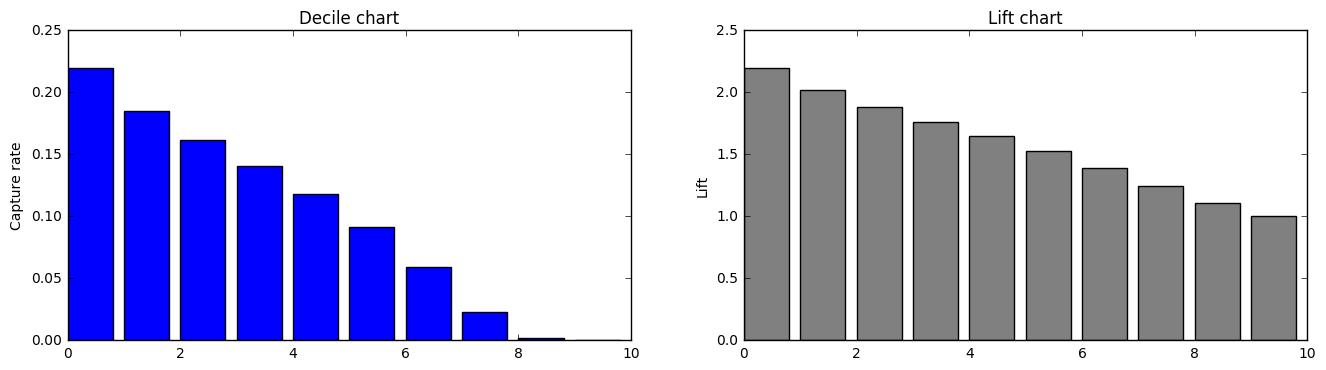

In [60]:
# Top decile, 5% capture, decile chart and lift chart
per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print 'Probability from classifier for Train' 
print 'Response 10%: ' + str(dec_1_rr)
print 'Capture at 10%: ' + str(dec_1_cr)
print 'Response 5%: ' + str(per5_1_rr)
print 'Capture at 5%: ' + str(per5_1_cr)

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(xrange(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(xrange(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

## Decile Info - Validation

In [62]:
# Validation AUC
val_pred_xgb_log2 = xgb_log2.predict_proba(X_val)
print('Validation AUC: ' + str(roc_auc_score(Y_val, val_pred_xgb_log2[:,1])))
print('Validation Log Loss: ' + str(log_loss(Y_val, val_pred_xgb_log2[:,1])))

Validation AUC: 0.817448809024
Validation Log Loss: 0.485953399092


In [63]:
# Decile related info
df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(val_pred_xgb_log2[:,1]) 
prob.columns = ['Probability']
prob["Target"] = Y_val.values 
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [64]:
# Decile info dataframe
df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

,# decile,# of goods,# of bads,1st decile capture_rate,1st decile response_rate,% of bads,% cum_goods,% cum_bads,KS,Lift
0,8085,6287.0,1798.0,0.211826,0.777613,0.035138,0.211826,0.035138,0.483644,2.118471
1,8085,5177.0,2908.0,0.174427,0.640322,0.056830,0.386253,0.091968,0.483644,1.931458
2,8085,4703.0,3382.0,0.158457,0.581694,0.066093,0.544710,0.158061,0.483644,1.815880
3,8085,4111.0,3974.0,0.138511,0.508472,0.077663,0.683221,0.235724,0.483644,1.708222
4,8085,3647.0,4438.0,0.122877,0.451082,0.086731,0.806098,0.322455,0.483644,1.612356
5,8085,2799.0,5286.0,0.094306,0.346197,0.103303,0.900404,0.425757,0.483644,1.500822
6,8085,1908.0,6177.0,0.064286,0.235993,0.120715,0.964690,0.546473,0.483644,1.378265
7,8085,859.0,7226.0,0.028942,0.106246,0.141216,0.993632,0.687688,0.483644,1.242163
8,8085,186.0,7899.0,0.006267,0.023006,0.154368,0.999899,0.842056,0.483644,1.111109
9,8085,3.0,8082.0,0.000101,0.000371,0.157944,1.000000,1.000000,0.483644,1.000099


Probability from classifier for Validation
Response 10%: 0.777612863327
Capture at 10%: 0.211826145553
Response 5%: 0.816427511133
Capture at 5%: 0.111185983827


(<Container object of 10 artists>,
 <matplotlib.text.Text at 0x7f6af2d98ad0>)

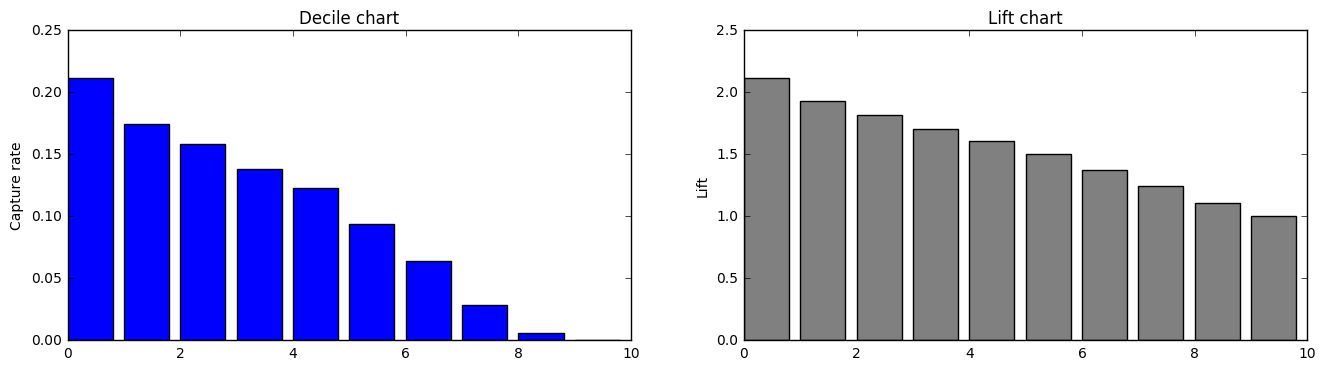

In [65]:
# Top decile, 5% capture, decile chart and lift chart

per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print 'Probability from classifier for Validation'
print 'Response 10%: ' + str(dec_1_rr)
print 'Capture at 10%: ' + str(dec_1_cr)
print 'Response 5%: ' + str(per5_1_rr)
print 'Capture at 5%: ' + str(per5_1_cr)

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(xrange(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(xrange(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

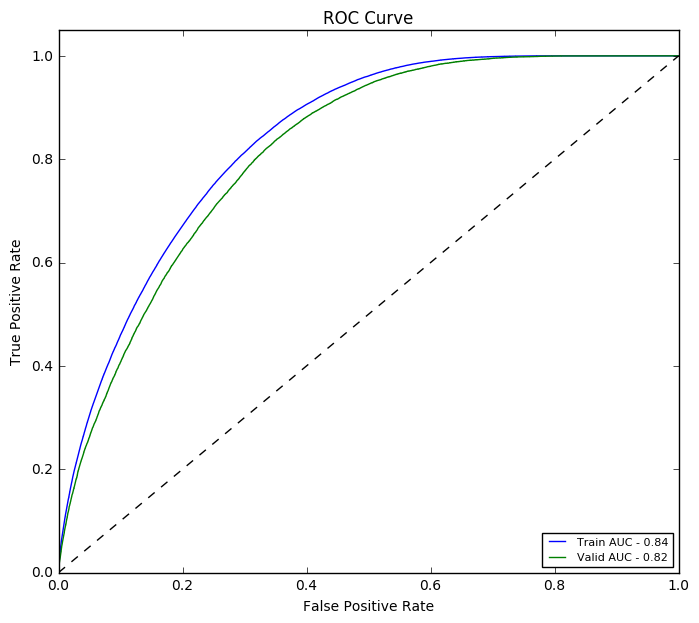

In [66]:
# Make ROC curve for train and validation as of now
from sklearn.metrics import roc_curve, auc

fpr_trn, tpr_trn, _= roc_curve(Y_train, y_predS_xgb_log2[:,1])
fpr_tst, tpr_tst, _= roc_curve(Y_val, val_pred_xgb_log2[:, 1]) 

roc_auc_trn = auc(fpr_trn, tpr_trn)
roc_auc_tst = auc(fpr_tst, tpr_tst)
# print roc_auc

# Plot of a ROC curve
plt.figure(figsize=(8,7))
plt.plot(fpr_trn, tpr_trn, label='Train AUC - %0.2f' % roc_auc_trn)
plt.plot(fpr_tst, tpr_tst, label='Valid AUC - %0.2f' % roc_auc_tst)   # Valid or Test ???
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right", prop={'size':8})
# plt.savefig('ROC_Curve.png')

In [67]:
feat_imp = pd.Series(xgb_log2.booster().get_fscore()).sort_values(ascending=False)
feat_imp =pd.DataFrame({'features': feat_imp.index, 'importance' : feat_imp.values})
feat_imp['importance_percent']  = feat_imp['importance']/feat_imp['importance'].sum()

In [68]:
feat_imp.iloc[0:21]

,features,importance,importance_percent
0,q1_form_char,3254,0.088292
1,q2_form_char,3182,0.086338
2,q_ratio,3030,0.082214
3,q2_length,2417,0.065581
4,partial_ratio,2394,0.064957
5,prcnt_common,2346,0.063655
6,token_sort_ratio,2345,0.063628
7,q1_length,2163,0.058689
8,token_set_ratio,2089,0.056682
9,partial_token_sort_ratio,2073,0.056247


In [69]:
def draw_feature_importance(fea_imp_df, nb, imp_col):
    fea_imp_df = fea_imp_df.sort_values(imp_col).reset_index(drop=True)
    fea_imp_df = fea_imp_df[-1*nb:].reset_index(drop=True)

    plt.figure(figsize=(10, nb*0.3))
    plt.title("Top %d Most Important Features"%nb)
    plt.barh(fea_imp_df.index, fea_imp_df[imp_col], color='#348ABD', align="center", lw='2', edgecolor='#348ABD', alpha=0.6)
    plt.yticks(fea_imp_df.index, fea_imp_df['features'], fontsize=12,)
    plt.ylim([-1, nb])
    plt.xlim([0, fea_imp_df[imp_col].max()*1.1])
    plt.show()

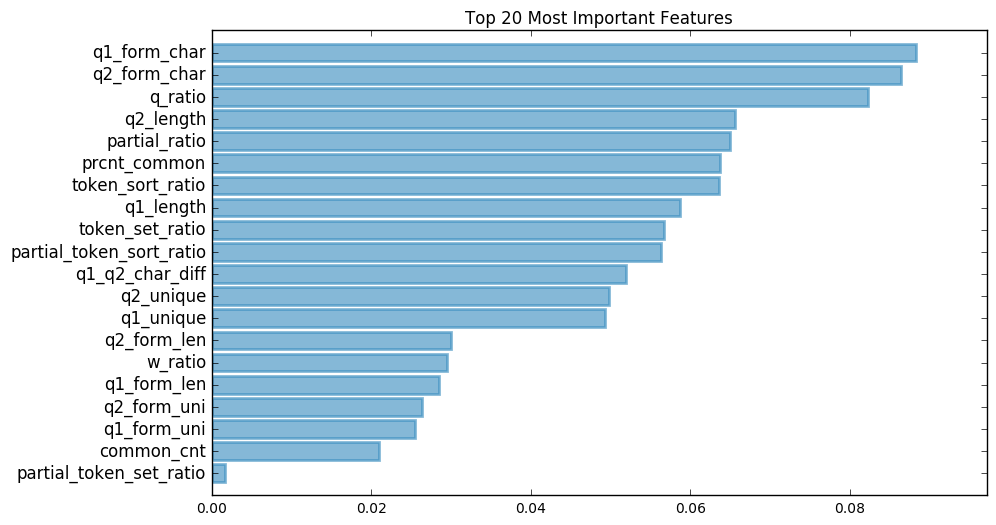

In [70]:
draw_feature_importance(feat_imp, feat_imp.shape[0], 'importance_percent')

In [71]:
# RUNNING THE FINAL SELECTED MODEL ON THE FULL TRAINING DATASET

In [72]:
# xgboost fn
def modelfit2(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=val_dup[[0]].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=['logloss'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    alg.fit(dtrain[predictors], np.ravel(val_dup),eval_metric='logloss')     #Fit algorithm

    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    print("AUC Score (Train): %f" % roc_auc_score(np.ravel(val_dup), dtrain_predprob))
    print("LogLoss Score (Train): %f" % log_loss(np.ravel(val_dup), dtrain_predprob))
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

Will train until cv error hasn't decreased in 50 rounds.


AUC Score (Train): 0.834804
LogLoss Score (Train): 0.468760


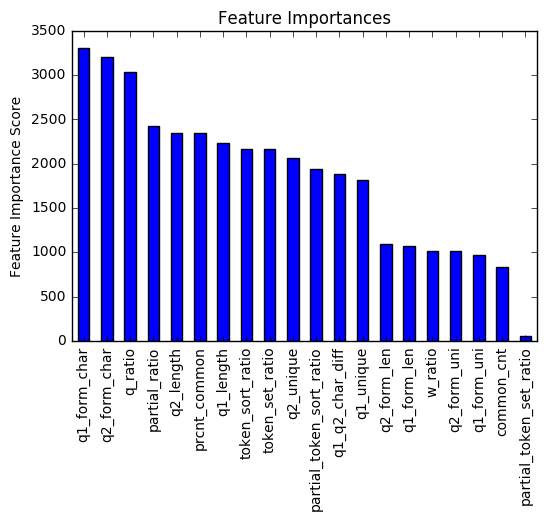

In [75]:
# Using the final model on the initial given full training dataset
xgb_log3 = XGBClassifier( max_depth= 6, min_child_weight= 1, gamma=0.2, colsample_bytree=0.8, subsample=0.7, 
                    reg_alpha = 1, reg_lambda = 0, max_delta_step = 3, scale_pos_weight= 1, learning_rate = 0.05, 
                    n_estimators=700, objective= 'binary:logistic', nthread=4, seed=45)

#Choose the predictors for xgboost and fit the model
# predictors  = list(train_basic_fuzzy.columns)
modelfit2(xgb_log3, train_basic_fuzzy, predictors)

In [76]:
# Train roc auc
y_predS_final = xgb_log3.predict_proba(train_basic_fuzzy)
print('Validation AUC: ' + str(roc_auc_score(val_dup, y_predS_final[:,1]) ))
print('Validation Log Loss: ' + str(log_loss(val_dup, y_predS_final[:,1]) ))

Validation AUC: 0.834804339102
Validation Log Loss: 0.468759572228


In [78]:
# Cross validation AUC & LogLoss
cv_score_final = cross_val_score(xgb_log3, train_basic_fuzzy, np.ravel(val_dup), cv = 5, scoring ='roc_auc')
print('mean auc: ' + str(cv_score_final.mean()))
print('std auc: ' + str(cv_score_final.std()))
cv_score1_final = cross_val_score(xgb_log3, train_basic_fuzzy, np.ravel(val_dup), cv = 5, scoring ='log_loss')
print 'mean log_loss: ' + str(cv_score1_final.mean())
print 'std log_loss: ' + str(cv_score1_final.std())

mean auc: 0.818548767597
std auc: 0.00101343037976
mean log_loss: -0.485472112447
std log_loss: 0.00101384668486


In [77]:
# Save the model
from sklearn.externals import joblib
joblib.dump(xgb_log3, '/home/pgoyal/quora/model3/xgb_log3_dup_logloss.pkl')

['/home/pgoyal/quora/model3/xgb_log3_dup_logloss.pkl',
 '/home/pgoyal/quora/model3/xgb_log3_dup_logloss.pkl_01.npy']